# Configuration

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse, precision_recall_fscore_support, accuracy_score, confusion_matrix

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures

# Importing dataset 

In [3]:
std_df = pd.read_csv('processed_dataset/std_dataset.csv', index_col = 0)
std_df.shape

(36733, 39)

In [4]:
dev_df = std_df.loc[:24487,:]
dev_df.shape

(24488, 39)

In [5]:
eval_df = std_df.loc[24488:, :]
eval_df.shape

(12245, 39)

In [6]:
ambiental_pred = ['AT', 'AP', 'AH']
process_pred = ['AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
location_pred = ['Austria', 'Belgium', 'Bulgaria', 'Croatia',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal',
       'Republic of Cyprus', 'Romania', 'Slovakia', 'Slovenia', 'Spain',
       'Sweden']
nox = ['NOX']
year = ['YEAR']

In [7]:
features_lists = [
    'all',
    ambiental_pred,
    process_pred,
    ambiental_pred+nox,
    ambiental_pred+year,
    ambiental_pred+nox+year,
    process_pred+nox,
    process_pred+year,
    process_pred+nox+year,
    ambiental_pred+process_pred,
    ambiental_pred+process_pred+nox,
    ambiental_pred+process_pred+year,
    ambiental_pred+process_pred+nox+year,
]

# Model building 

In [ ]:
class Model():
    
    def __init__(self, model_classifier, standard_regressor, extreme_regressor):
        
        self.classifier = model_classifier
        self.std_regr = standard_regressor
        self.ext_regr = extreme_regressor
        self.std_columns = 'all'
        self.ext_columns = 'all'
        
        
    def fit(self, X, co_values, binary_labels, std_columns = 'all', ext_columns = 'all'):
        
        print('Fitting the classifier.....')
        self.classifier.fit(X,binary_labels)
        print('Classifier fitted')
        
        mask = binary_labels.values == 0
        
        if std_columns == 'all':
            std_X, std_co_values = X.loc[mask,:], co_values.loc[mask]
        else:
            self.std_columns = std_columns
            std_X, std_co_values = X.loc[mask,std_columns], co_values.loc[mask]
            
            
        if ext_columns == 'all':
            ext_X, ext_co_values = X.loc[~mask,:], co_values.loc[~mask]
        else:
            ext_X, ext_co_values = X.loc[~mask,ext_columns], co_values.loc[~mask]
            self.ext_columns = ext_columns
        
        print(std_X.shape, ext_X.shape)
        
        print('Fitting the standard regressor...')
        self.std_regr.fit(std_X, std_co_values)
        print('Standard Regressor fitted')
        print('Fitting the extreme regressor...')
        self.ext_regr.fit(ext_X, ext_co_values)
        print('Extrem Regressor fitted')
        
        return True
    
    def predict(self,X):
        
        pred_labels = self.classifier.predict(X)
        
        mask = pred_labels == 0
        
        if self.std_columns == 'all':
            std_X = X.loc[mask,:]
        else:
            std_X = X.loc[mask,self.std_columns]
          
        if self.ext_columns == 'all':
            ext_X = X.loc[~mask,:]
        else:
            ext_X = X.loc[~mask,self.ext_columns]
        
        
        print(type(self.std_columns))
        std_pred = self.std_regr.predict(std_X)
        ext_pred = self.ext_regr.predict(ext_X)
        
        y_pred = np.zeros(shape = pred_labels.shape)
        y_pred[mask] = std_pred
        y_pred[~mask] = ext_pred
        
        return y_pred, pred_labels
    
    def predict_weighted(self, X):
        
        posterior_probs = self.classifier.predict_proba(X)
        
        std_regressions = self.std_regr.predict(X)
        ext_regressions = self.ext_regr.predict(X)
        
        regressions = np.concatenate((std_regressions.reshape(-1,1), ext_regressions.reshape(-1,1)), axis = 1)
        
        y = (posterior_probs*regressions).sum(axis = 1)
        
        return y
        

### Dataset preparation

In [69]:
dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 4.5 else 1)
dev_df[['CO','labels']]

/tmp/ipykernel_4336/3230006167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['labels'] = dev_df['CO'].apply(lambda x : 0 if x < 4.5 else 1)


CO  labels
ID                     
0       1.07640       0
1      10.19600       1
2       0.78407       0
3       1.61530       0
4       1.40710       0
...         ...     ...
24483   1.60010       0
24484   2.21050       0
24485   2.00960       0
24486   5.06680       1
24487   1.89830       0

[24488 rows x 2 columns]

In [70]:
dev_df['CO'].loc[dev_df['CO'] < 4.5,].count()

21652

In [71]:
dev_df['labels'].value_counts()

0    21652
1     2836
Name: labels, dtype: int64

In [130]:
X = dev_df[ambiental_pred+process_pred+nox+year]
co_values = dev_df['CO']
labels = dev_df['labels']



poly = PolynomialFeatures(degree = 3)
X = poly.fit_transform(X.drop(columns= ['TEY', 'CDP']))
X = pd.DataFrame(X, columns = poly.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X, pd.DataFrame({'CO': co_values, 'labels':labels}),
                                                    random_state=42, test_size=0.25,
                                                    stratify=dev_df['labels'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train.head()

1        AT        AP        AH      AFDP      GTEP       TIT  \
5507   1.0 -1.139790  0.086488  1.411285  1.772403 -0.386988  0.177419   
9251   1.0 -1.157682  1.075364  0.501192 -1.095430 -0.428049  0.137443   
11795  1.0  1.014986  0.380061 -0.666055  0.605685  1.167599  1.062590   
6770   1.0 -0.724144 -0.825132  0.056196 -0.743982 -0.147306 -0.045302   
13372  1.0  1.396374 -0.068024 -0.855617  0.140056 -0.046086 -0.056724   

            TAT       NOX  YEAR  ...     TAT^3  TAT^2 NOX  TAT^2 YEAR  \
5507   0.541670  1.019515   5.0  ...  0.158929   0.299132    1.467030   
9251   0.516776  1.822497   3.0  ...  0.138009   0.486712    0.801174   
11795 -1.238932 -0.417629   5.0  ... -1.901704  -0.641041    7.674768   
6770   0.540205 -0.184487   1.0  ...  0.157644  -0.053837    0.291822   
13372  0.563634 -1.684864   2.0  ...  0.179057  -0.535254    0.635367   

       TAT NOX^2  TAT NOX YEAR  TAT YEAR^2     NOX^3  NOX^2 YEAR  NOX YEAR^2  \
5507    0.563017      2.761202   13.541743  1.059695    5.197054   25.487874   
9251    1.716471      2.825471    4.650988  6.053418    9.964489   16.402476   
11795  -0.216087      2.587069  -30.973310 -0.072840    0.872069  -10.440720   
6770    0.018386     -0.099661    0.540205 -0.006279    0.034036   -0.184487   
13372   1.600027     -1.899295    2.254538 -4.782937    5.677535   -6.739457   

       YEAR^3  
5507    125.0  
9251     27.0  
11795   125.0  
6770      1.0  
13372     8.0  

[5 rows x 220 columns]

### Random Forest

In [136]:
clf = RandomForestClassifier(n_estimators= 400, min_samples_split=2, min_samples_leaf=1, 
                             max_features= 'log2', max_depth = 110,
                             random_state=42)

std_regr = RandomForestRegressor(n_estimators=300, min_samples_split=4, 
                                 min_samples_leaf=2, max_features='sqrt',
                                 max_depth=20, bootstrap = False, 
                                 random_state = 42)

ext_regr = RandomForestRegressor(random_state = 42, 
                                 n_estimators = 300, 
                                 min_samples_split=4, min_samples_leaf = 1, 
                                 max_features='sqrt',
                                 max_depth=60,
                                 bootstrap=False)

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr) #messo default


model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Fitting the classifier.....
Classifier fitted
(16239, 220) (2127, 220)
Fitting the standard regressor...
Standard Regressor fitted
Fitting the extreme regressor...
Extrem Regressor fitted


True

In [141]:
y_pred= model.predict_weighted(X_test)

In [142]:
mse(y_test['CO'].values, y_pred)

1.1309032000592374

In [143]:
#Submit
evaluation = poly.transform(eval_df.loc[:,:'NOX'].drop(columns = ['TEY', 'CDP']))
evaluation = pd.DataFrame(evaluation, columns = poly.get_feature_names_out())
print(evaluation.shape)
pred = model.predict_weighted(evaluation)
print(pred)

/home/edoardo/Desktop/DSL_2021/dsl_venv/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


(12245, 220)
[ 3.70626198 13.02254623  4.34555383 ... 10.22708379  5.30661514
  4.13694146]


In [140]:
not_equal = 0
for i in range(len(evaluation.columns)):
    if evaluation.columns[i] !=  X_test.columns[i]:
        not_equal += 1 
        
not_equal

0

In [119]:
len(pred)

12245

In [144]:
submission_df = pd.DataFrame(columns=['Id','Predicted'])
submission_df

Empty DataFrame
Columns: [Id, Predicted]
Index: []

In [145]:
submission_df['Id'] = eval_df.reset_index()['ID']
submission_df['Predicted'] = pred
submission_df.head()

Id  Predicted
0  24488   3.706262
1  24489  13.022546
2  24490   4.345554
3  24491  11.968565
4  24492   9.606434

In [146]:
submission_df.to_csv("submission/rfclf_rfregr_poly3.csv", index=False)

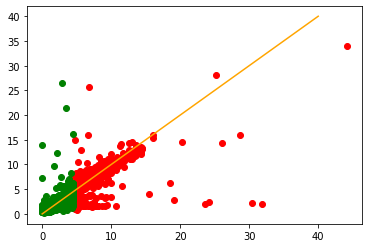

In [26]:
plt.scatter(y_test['CO'].loc[y_test['labels'] == 1].values, y_pred[y_test['labels'] == 1], c = 'red')
plt.scatter(y_test['CO'].loc[y_test['labels'] == 0].values, y_pred[y_test['labels'] == 0], c = 'green')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'orange')

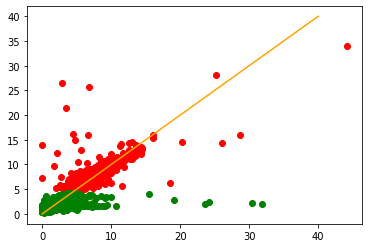

In [28]:
plt.scatter(y_test['CO'].loc[pred_labels == 1].values, y_pred[pred_labels == 1], c = 'red')
plt.scatter(y_test['CO'].loc[pred_labels == 0].values, y_pred[pred_labels == 0], c = 'green')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'orange')

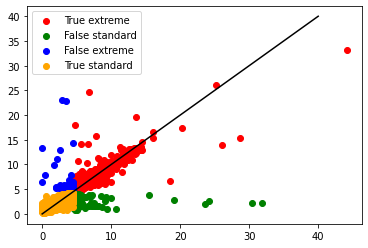

In [26]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

In [27]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5328,   85],
       [ 140,  569]])

### SVM classifier

In [68]:
clf = SVC(random_state=42)
std_regr = RandomForestRegressor(random_state = 42)
ext_regr = RandomForestRegressor(random_state = 42)

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)
model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Classifier fitted
(16239, 37) (2127, 37)
Standard Regressor fitted
Extrem Regressor fitted


True

In [69]:
y_pred, pred_labels = model.predict(X_test, y_test['labels'])

In [73]:
mse(y_test['CO'].values, y_pred)

1.4861789733783997

In [74]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5317,   96],
       [ 192,  517]])

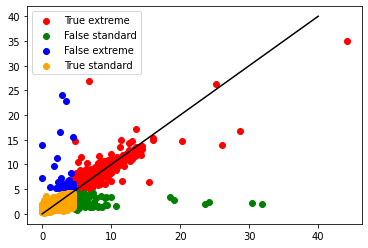

In [75]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

### MLP Classifier

In [134]:
clf = MLPClassifier(random_state=42, max_iter = 10000)
std_regr = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=2, max_features=None,
                                 max_depth=30, bootstrap=True, 
                                 random_state = 42)

ext_regr = RandomForestRegressor(random_state = 42, n_estimators = 500, 
                                 min_samples_split=2, min_samples_leaf = 1, 
                                 max_features='sqrt')

model = Model(model_classifier = clf, standard_regressor = std_regr, extreme_regressor=ext_regr)
model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Classifier fitted
(16239, 11) (2127, 11)
Standard Regressor fitted
Extrem Regressor fitted


True

In [135]:
y_pred, pred_labels = model.predict(X_test, y_test['labels'])

<class 'str'>


In [136]:
mse(y_test['CO'].values, y_pred)

1.3527174273452256

In [137]:
confusion_matrix(y_test['labels'], pred_labels)

array([[5314,   99],
       [ 146,  563]])

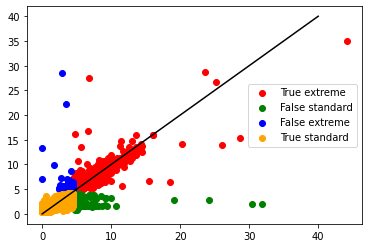

In [133]:
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 1)], c = 'red', label = 'True extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 1) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 1) & (pred_labels == 0)], c = 'green', label = 'False standard')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 1)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 1)], c = 'blue', label = 'False extreme')
plt.scatter(y_test['CO'].loc[(y_test['labels'] == 0) & (pred_labels == 0)].values, y_pred[(y_test['labels'] == 0) & (pred_labels == 0)], c = 'orange', label = 'True standard')
plt.plot(np.linspace(0,40), np.linspace(0,40), c = 'black')
plt.legend()

# Logistic Regression

In [35]:
clf = LogisticRegression(max_iter = 10000)
std_regr = RandomForestRegressor(n_estimators=300, min_samples_split=4, 
                                 min_samples_leaf=2, max_features='sqrt',
                                 max_depth=20, bootstrap = False, 
                                 random_state = 42)

ext_regr = RandomForestRegressor(random_state = 42, 
                                 n_estimators = 300, 
                                 min_samples_split=4, min_samples_leaf = 1, 
                                 max_features='sqrt',
                                 max_depth=60,
                                 bootstrap=False)

model = Model(model_classifier= clf, standard_regressor = std_regr, extreme_regressor = ext_regr)

model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])



Fitting the classifier.....
Classifier fitted
(16239, 220) (2127, 220)
Fitting the standard regressor...
Standard Regressor fitted
Fitting the extreme regressor...
Extrem Regressor fitted


True

In [40]:
pred = model.predict_weighted(X_test)
mse(y_test['CO'], pred)

[[4.01812910e-01 5.98187090e-01]
 [9.99879499e-01 1.20500797e-04]
 [9.97571392e-01 2.42860817e-03]
 [9.99702742e-01 2.97257513e-04]
 [9.95367263e-01 4.63273732e-03]]
[4.006483   0.42619516 0.67721833 0.93173534 1.26787393]
[ 5.11137628 11.07662767  6.40445956  5.7831285   7.29793322]
[[ 4.006483    5.11137628]
 [ 0.42619516 11.07662767]
 [ 0.67721833  6.40445956]
 [ 0.93173534  5.7831285 ]
 [ 1.26787393  7.29793322]]


1.3371709286470297

# ExtraTree

In [82]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
clf = ExtraTreesClassifier(random_state = 42)

std_regr = ExtraTreesRegressor(random_state = 42)

ext_regr = ExtraTreesRegressor(random_state = 42)

model = Model(model_classifier= clf, standard_regressor = std_regr, extreme_regressor = ext_regr)

model.fit(X_train, co_values= y_train['CO'], binary_labels=y_train['labels'])

Fitting the classifier.....
Classifier fitted
(16239, 220) (2127, 220)
Fitting the standard regressor...
Standard Regressor fitted
Fitting the extreme regressor...
Extrem Regressor fitted


True

In [83]:
pred = model.predict_weighted(X_test)
mse(y_test['CO'], pred)

1.160703401031832

# Ensemble method

In [27]:
dev_df['AT'].mean()

3.847515793931284e-16

In [16]:
Xy = dev_df.loc[:,:'CO']
Xy['labels'] = Xy['CO'].apply(lambda x : 0 if x <=4.5 else 1)

ix = pd.IndexSlice

grouped = Xy.groupby('labels').describe().loc[slice(None),ix[:,['mean','std']]]
grouped.loc[0].loc[ix[:,'mean']]

YEAR    3.056897
AT      0.055846
AP     -0.006081
AH     -0.053063
AFDP    0.138883
GTEP    0.165964
TIT     0.222274
TAT    -0.011829
TEY     0.180834
CDP     0.174814
NOX    -0.113742
CO      1.777638
Name: 0, dtype: float64

In [144]:
class Classifier():
    
    def __init__(self, n_features = 3, threshold = 0.5):
        self.n_features = n_features
        self.threshold = threshold
        self.ix = pd.IndexSlice
        
        
    def fit(self, X):
        self.features = list(X.loc[:,:'NOX'].sample(n=self.n_features, axis = 1).columns)
        self.mean_std = X.groupby(by= 'labels').describe().loc[slice(None),self.ix[self.features,['mean','std']]]
        
    def predict(self, X):
        result = X[self.features].copy()
        for col in self.features:
            result[col] = result[col].apply(lambda x : labeling(x, self.mean_std[col]))
        result = (result.sum(axis = 1)/len(result.loc[:'NOX'].columns)).apply(lambda x : 0 if x<self.threshold else 1)
        return result.values
        
    def labeling(self, x, mean_std_col):
        mean,std = mean_std_col.loc[1].values
        label = 0
        lower = mean-std
        upper = mean+std
        if lower <= x <= upper:
            label = 1
        return label
    

class EnsembleClassifier():
    
    def __init__(self, n_estimators = 100, n_features_per_estimator = 3, threshold = 0.5):
        self.n_estimators = n_estimators
        self.n_features_per_estimator = n_features_per_estimator
        self.threshold = threshold
        self.estimators = [Classifier(n_features = n_features_per_estimator ,threshold = threshold) for i in range(n_estimators)]
        
    def fit(self, X):
        for est in self.estimators:
            est.fit(X)
        
    def predict(self, X):
        
        predictions = np.array([est.predict(X) for est in self.estimators])
        print(predictions)
        predictions = (predictions.sum(axis = 0) / self.n_estimators)
        print(predictions)
        predictions = np.array(list(map(lambda x : 0 if x<self.threshold else 1, predictions)))
        
        return predictions
    
        

In [126]:
clf = Classifier()
clf.fit(Xy)

pred = clf.predict(Xy.loc[:20,:'NOX'])

print(np.array(pred))    

[0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0]


In [150]:
en_clf = EnsembleClassifier(n_estimators = 10, n_features_per_estimator=4)
en_clf.fit(Xy)
pred = en_clf.predict(Xy.loc[:20,:'NOX'])
pred

[[0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1]
 [0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1]
 [0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
[0.6 0.9 0.5 1.  0.3 0.1 0.7 0.  0.5 0.6 0.8 0.2 0.8 0.8 0.7 0.5 0.8 0.5
 0.3 0.1 0.5]


array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])